# API TOKENS 

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret0 = user_secrets.get_secret("hf_write")
secret1 = user_secrets.get_secret("hface_read")
secret2 = user_secrets.get_secret("wandb")

# HUGGING FACE MODEL/DATASET PULL

In [6]:
import os
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset
import wandb
from huggingface_hub import HfApi, login

# Set model and dataset names
model_name = "HuggingFaceTB/SmolLM2-360M-Instruct"
dataset_name = "wikitext"
dataset_config = "wikitext-2-raw-v1"

RUN_NAME="finetune-smolLM2-360M-INSTRUCT-LR-1e-3"

WANDB_INIT_PROJECT="distilgpt2-finetuning"
WANDB_INIT_NAME=RUN_NAME
WANDB_INIT_ENTITY="qbizm"

HF_REPO_NAME="Fine-Tuning-DLSE-Smol2/"+RUN_NAME



wandb.login(key=secret2)
# Initialize a W&B run
wandb.init(project=WANDB_INIT_PROJECT, name=WANDB_INIT_NAME, entity=WANDB_INIT_ENTITY)

# Step 2: Login to Hugging Face
login(token=secret0)  

# Step 3: Load the dataset
dataset = load_dataset(dataset_name, dataset_config)

# Step 4: Prepare the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 
model = AutoModelForCausalLM.from_pretrained(model_name)



wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: michaelj1 (qbizm). Use `wandb login --relogin` to force relogin


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


# FINE - TUNING

In [ ]:
# Step 5: Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

# Step 6: Prepare data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)




In [ ]:
# Step 7: Set up training arguments

training_args = TrainingArguments(
    output_dir="./"+RUN_NAME,
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    save_steps=50,
    save_total_limit=2,
    logging_steps=1,
    eval_strategy="steps", 
    eval_steps=50,
    learning_rate=1e-3,
    weight_decay=0.01,
    fp16=True,
    report_to="wandb",
    run_name=RUN_NAME,
)

# Step 8: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
)

# Step 9: Fine-tune the model
trainer.train()

# Step 10: Evaluate the model
trainer.evaluate()

# Finish the W&B run
wandb.finish()

#  Save and push the model to Hugging Face Hub

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

user_info = api.whoami(token=secret0)
username = user_info['name']
print(f"Your username is: {username}")

In [ ]:
from huggingface_hub import HfApi, login
from kaggle_secrets import UserSecretsClient
from transformers import Trainer, AutoTokenizer
import os

# Access Hugging Face credentials
user_secrets = UserSecretsClient()
secret0 = user_secrets.get_secret("hf_write")

# Login to Hugging Face Hub
login(token=secret0, add_to_git_credential=True)

# Create a private repository if it doesn’t exist
api = HfApi()
api.create_repo(
    repo_id=HF_REPO_NAME, 
    token=secret0,
    private=True,
    repo_type="model",
    exist_ok=True,
)

# Define the save directory
save_directory = "/kaggle/working/"+RUN_NAME

# Save the model and tokenizer to the same directory
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

# Verify contents in the directory
print("Files saved in directory:", os.listdir(save_directory))

# Push entire directory to the repository using HfApi
api.upload_folder(
    folder_path=save_directory,
    path_in_repo="",  # Root of the repository
    repo_id=HF_REPO_NAME,
    token=secret0,
)


# EVALUATION METRICS

In [2]:
!pip install rouge_score


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4541d41b7704a37976b2128021ee806141e72d87eb731fc2e5e1b9a51af872d4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Loading model and tokenizer for HuggingFaceTB/SmolLM2-360M-Instruct...
Loading model and tokenizer for Fine-Tuning-DLSE-Smol2/finetune-smolLM2-360M-INSTRUCT-LR-1e-3...

Evaluating model HuggingFaceTB/SmolLM2-360M-Instruct on validation subset...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Evaluating: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]



Model: HuggingFaceTB/SmolLM2-360M-Instruct
Perplexity on Validation Subset: 29.40
Average BLEU Score: 0.0044
Average ROUGE-1 Score: 0.1723

Evaluating model Fine-Tuning-DLSE-Smol2/finetune-smolLM2-360M-INSTRUCT-LR-1e-3 on validation subset...


Evaluating: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Model: Fine-Tuning-DLSE-Smol2/finetune-smolLM2-360M-INSTRUCT-LR-1e-3
Perplexity on Validation Subset: 115.20
Average BLEU Score: 0.0057
Average ROUGE-1 Score: 0.1667



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


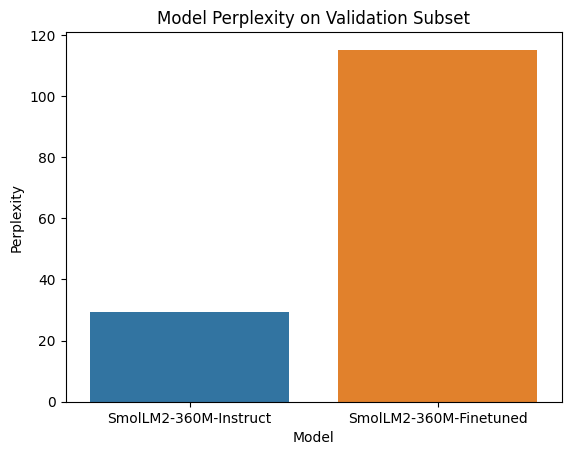

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


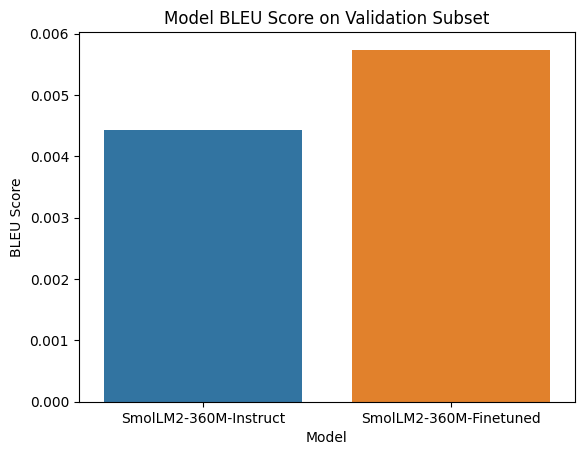

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


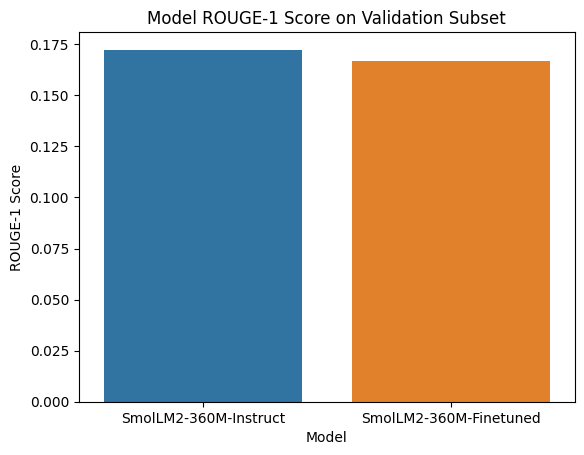

In [11]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import DataCollatorForLanguageModeling
import matplotlib.pyplot as plt
import seaborn as sns
import math
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm import tqdm
import random
import nltk

# Install necessary NLTK data
nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset (validation split only)
dataset_name = "wikitext"
dataset_config = "wikitext-2-raw-v1"
raw_dataset = load_dataset(dataset_name, dataset_config, split='validation')

# Randomly select a subset of 300 examples from the validation set
subset_size = 300
random.seed(42)  # For reproducibility
subset_indices = random.sample(range(len(raw_dataset)), subset_size)
subset_dataset = raw_dataset.select(subset_indices)

# Model and tokenizer names
model_names = [
    "HuggingFaceTB/SmolLM2-360M-Instruct",
    HF_REPO_NAME
]

models = {}
tokenizers = {}

# Load models and tokenizers
for name in model_names:
    print(f"Loading model and tokenizer for {name}...")
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForCausalLM.from_pretrained(name).to(device)
    tokenizers[name] = tokenizer
    models[name] = model

# Define evaluation function with BLEU and ROUGE-1 metrics
def evaluate(model, tokenizer, dataset):
    model.eval()
    bleu_scores = []
    rouge1_scores = []
    total_loss = 0
    total_tokens = 0

    smoothing_function = SmoothingFunction().method1
    rouge_scorer_fn = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    for example in tqdm(dataset, desc="Evaluating"):
        text = example['text']
        # Skip empty or very short texts
        if len(text.strip()) == 0 or len(text.strip().split()) < 5:
            continue

        # Split the text into prompt and reference
        sentences = nltk.sent_tokenize(text)
        if len(sentences) < 2:
            continue  # Need at least one sentence for prompt and one for reference

        prompt = sentences[0]
        reference = ' '.join(sentences[1:])

        # Encode the prompt
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

        # Generate continuation
        max_new_tokens = 50  # Adjust as needed
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            early_stopping=True
        )
        # Decode the generated text
        generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        # Remove the prompt from the generated text
        generated_continuation = generated_text[len(prompt):].strip()

        # Compute BLEU score
        reference_tokens = nltk.word_tokenize(reference.lower())
        generated_tokens = nltk.word_tokenize(generated_continuation.lower())
        if len(generated_tokens) == 0 or len(reference_tokens) == 0:
            continue  # Skip if unable to tokenize
        bleu_score = sentence_bleu(
            [reference_tokens],
            generated_tokens,
            smoothing_function=smoothing_function
        )
        bleu_scores.append(bleu_score)

        # Compute ROUGE-1 score
        rouge_score = rouge_scorer_fn.score(reference, generated_continuation)
        rouge1_scores.append(rouge_score['rouge1'].fmeasure)

        # Compute perplexity (loss over the reference)
        with torch.no_grad():
            labels = tokenizer.encode(reference, return_tensors='pt').to(device)
            inputs = torch.cat([input_ids, labels], dim=1)
            outputs = model(input_ids=inputs, labels=inputs)
            loss = outputs.loss
            total_loss += loss.item() * labels.numel()
            total_tokens += labels.numel()

    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    perplexity = math.exp(total_loss / total_tokens) if total_tokens > 0 else float('inf')

    return perplexity, avg_bleu, avg_rouge1

# Evaluate models on the subset of validation data
metrics = {}

for name in model_names:
    print(f"\nEvaluating model {name} on validation subset...")
    model = models[name]
    tokenizer = tokenizers[name]
    perplexity, avg_bleu, avg_rouge1 = evaluate(model, tokenizer, subset_dataset)
    metrics[name] = {
        'perplexity': perplexity,
        'bleu': avg_bleu,
        'rouge1': avg_rouge1
    }
    print(f"\nModel: {name}")
    print(f"Perplexity on Validation Subset: {perplexity:.2f}")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")

# Visualize evaluation metrics
model_display_names = [
    "SmolLM2-360M-Instruct",
    "SmolLM2-360M-Finetuned"
]

# Prepare data for visualization
metric_names = ['perplexity', 'bleu', 'rouge1']
metric_display_names = {
    'perplexity': 'Perplexity',
    'bleu': 'BLEU Score',
    'rouge1': 'ROUGE-1 Score'
}

for metric in metric_names:
    values = [metrics[name][metric] for name in model_names]
    plt.figure()
    sns.barplot(x=model_display_names, y=values)
    plt.title(f'Model {metric_display_names[metric]} on Validation Subset')
    plt.ylabel(metric_display_names[metric])
    plt.xlabel('Model')
    plt.show()


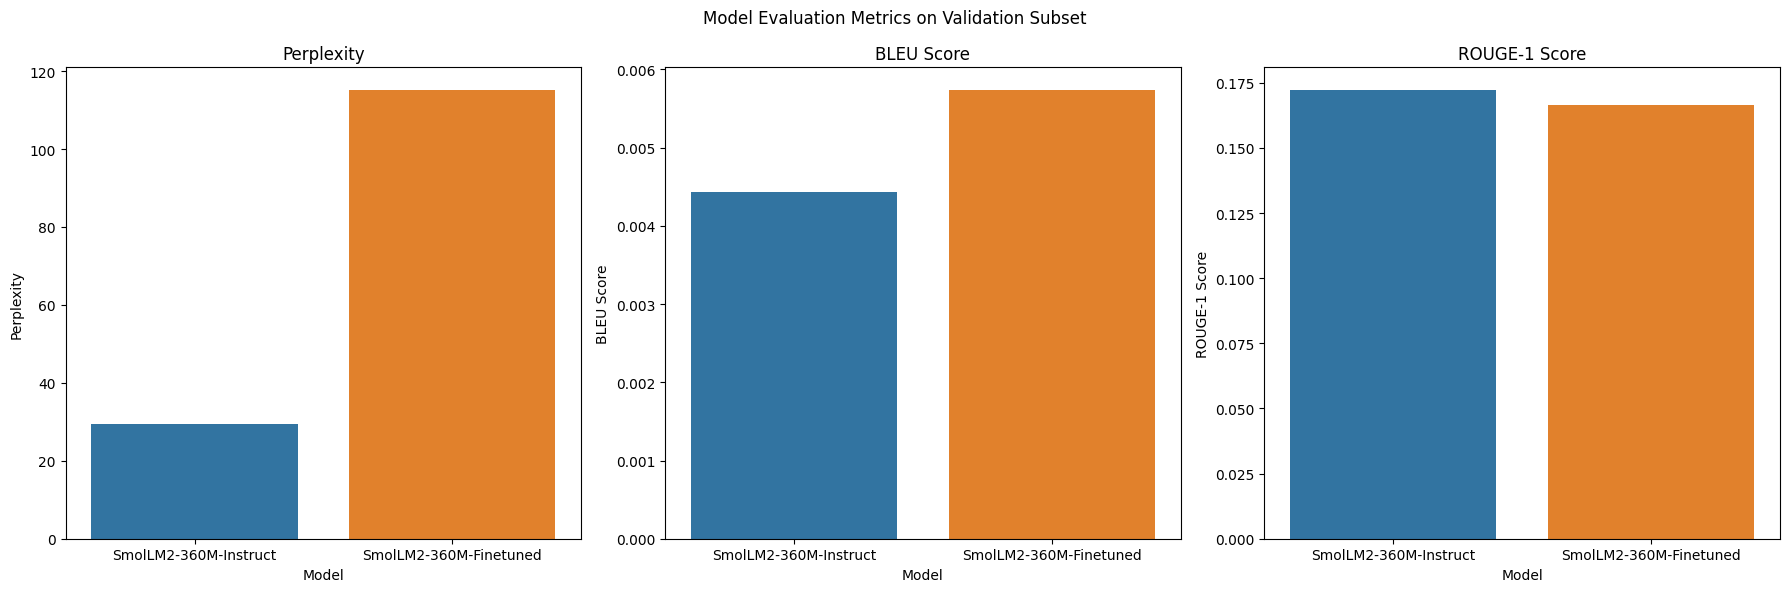

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


data = []
for name, display_name in zip(model_names, model_display_names):
    for metric in metric_names:
        data.append({
            'Model': display_name,
            'Metric': metric_display_names[metric],
            'Value': metrics[name][metric]
        })

df = pd.DataFrame(data)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    sns.barplot(data=df[df['Metric']==metric_display_names[metric]], x='Model', y='Value', ax=ax)
    ax.set_title(f'{metric_display_names[metric]}')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric_display_names[metric])

fig.suptitle('Model Evaluation Metrics on Validation Subset')
plt.tight_layout()
plt.show()


# TESTING

In [ ]:
# pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
#checkpoint = "HuggingFaceTB/SmolLM2-360M"
checkpoint = HF_REPO_NAME



device = "cuda" 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
inputs = tokenizer.encode("Dog is a ", return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
#checkpoint = "HuggingFaceTB/SmolLM2-360M-Instruct"
checkpoint = HF_REPO_NAME

device = "cuda" 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

messages = [{"role": "user", "content": "What is a cat in detail."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
#print(input_text)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=200, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))
